# Clew Based Genetic Algorithm

An example of how we could implement a 'Clew Based' genetric algorithm with easily swapable cost and crossover functions.

### General Setup

General Setup that can be shared between the different runs

In [10]:
# Various imports
import random
from src.algorithms.clew_ga import ClewBasedGeneticAlgorithm
from src.image_loading import load_image
from src.plotting import Drawing
from src.worm import CamoWorm, Clew
from src import rng

# Various Constants
POPULATION_SIZE = 40
CLEW_SIZE = 100

# Load the image
image = load_image("images", "original", (320, 560, 160, 880))

def random_clew_function() -> Clew:
    return [CamoWorm.random(image.shape) for _ in range(CLEW_SIZE)]

def iterate_and_print(algorithm: ClewBasedGeneticAlgorithm) -> None:
    for _ in range(10):
        results = algorithm.run_generations(10)

        print(
            f"({results[-1].generation:04}) {results[-1].costs[0]:.2f} {results[-1].duration}")
    
    best = algorithm.population[0].clew

    output = Drawing(image.copy())
    output.add_worms(best)
    output.show()

### Crossover functions

In [6]:
def fully_random_crossover(clew1: Clew, clew2: Clew) -> Clew:
    """ Worms essentially get randomly shuffled and can end up at any index. """
    cross_index = rng.integers(0, CLEW_SIZE)

    new_clew = random.choices(
        clew1, k=cross_index) + random.choices(clew2, k=(CLEW_SIZE-cross_index))

    return new_clew


def index_respecting_crossover(clew1: Clew, clew2: Clew) -> Clew:
    """ Worms will always remain at the same index and cannot change position
    in the clew. """
    cross_index = rng.integers(0, CLEW_SIZE)

    if random.random() > 0.5:
        new_clew = clew1[:cross_index] + clew2[cross_index:]
    else:
        new_clew = clew2[:cross_index] + clew1[cross_index:]

    return new_clew

### Cost functions

In [7]:
def max_width_cost_function(clew: Clew) -> float:
    cost = 0.0

    for worm in clew:
        cost += 1 / worm.width

    return cost

def min_width_cost_function(clew: Clew) -> float:
    cost = 0.0

    for worm in clew:
        cost += worm.width

    return cost

### Max Width

Max width using the fully random crossover function

(0010) 18.78 0.007159863016568124
(0020) 16.87 0.003933801024686545
(0030) 13.85 0.000827898969873786
(0040) 12.59 0.003983386035542935
(0050) 11.52 0.007791548036038876
(0060) 8.59 0.00429833703674376
(0070) 8.10 0.0007912539876997471
(0080) 6.73 0.0007576749776490033
(0090) 5.56 0.0007490870193578303
(0100) 5.17 0.004298240994103253


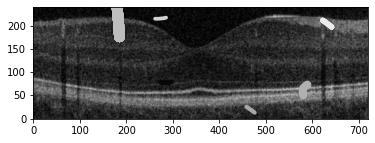

In [11]:
max_width_random_crossover = ClewBasedGeneticAlgorithm(
    POPULATION_SIZE, max_width_cost_function, random_clew_function, fully_random_crossover)

iterate_and_print(max_width_random_crossover)

Using the index respecting crossover

(0010) 20.93 0.00041763699846342206
(0020) 19.58 0.003433137957472354
(0030) 19.15 0.0034698600065894425
(0040) 18.62 0.006499267998151481
(0050) 18.26 0.00040178303606808186
(0060) 17.87 0.004139657015912235
(0070) 17.62 0.00409743603086099
(0080) 17.30 0.0003546960069797933
(0090) 17.24 0.004286872979719192
(0100) 17.18 0.011409541009925306


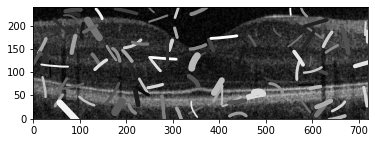

In [12]:
max_width_index_respecting = ClewBasedGeneticAlgorithm(
    POPULATION_SIZE, max_width_cost_function, random_clew_function, index_respecting_crossover)

iterate_and_print(max_width_index_respecting)

### Min Width

(0010) 405.26 0.007181165972724557
(0020) 381.02 0.0038257610285654664
(0030) 360.62 0.0038823469658382237
(0040) 338.97 0.0007654589717276394
(0050) 332.53 0.00394216098356992
(0060) 315.77 0.000776042987126857
(0070) 314.59 0.007056023983750492
(0080) 309.36 0.010135905991774052
(0090) 307.43 0.0038301979657262564
(0100) 304.31 0.006947173038497567


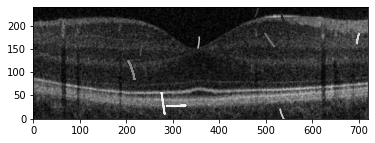

In [13]:
min_width_random_crossover = ClewBasedGeneticAlgorithm(
    POPULATION_SIZE, min_width_cost_function, random_clew_function, fully_random_crossover)

iterate_and_print(min_width_random_crossover)

(0010) 430.18 0.0033712940057739615
(0020) 413.39 0.000330157985445112
(0030) 405.50 0.0003647729754447937
(0040) 400.79 0.006722524005454034
(0050) 398.69 0.003408779972232878
(0060) 397.48 0.0003204190288670361
(0070) 397.17 0.003425939998123795
(0080) 395.61 0.0034823340247385204
(0090) 395.03 0.0033942950540222228
(0100) 391.02 0.0003214100142940879


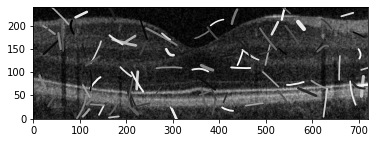

In [14]:
min_width_index_respecting = ClewBasedGeneticAlgorithm(
    POPULATION_SIZE, min_width_cost_function, random_clew_function, index_respecting_crossover)

iterate_and_print(min_width_index_respecting)